In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
import matplotlib.pyplot as plt

/Users/nikita/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import torch

In [3]:
# Загрузка данных (датафрейм с колонками 'date' и 'value')
btc = pd.read_csv('/Users/nikita/Desktop/monero/BTC.csv', sep=',', encoding='utf-8')

In [4]:
btc['close'] = btc['close'].str.replace('.', '')
btc['high'] = btc['high'].str.replace('.', '')
btc['low'] = btc['low'].str.replace('.', '')
btc['open'] = btc['open'].str.replace('.', '')
btc['volume'] = btc['volume'].str.replace('.', '')

btc['close'] = btc['close'].str.replace(',', '.').astype(float)
btc['high'] = btc['high'].str.replace(',', '.').astype(float)
btc['low'] = btc['low'].str.replace(',', '.').astype(float)
btc['open'] = btc['open'].str.replace(',', '.').astype(float)
btc['volume'] = btc['volume'].str.replace(',', '.')  # Remove commas

btc['volume'] = btc['volume'].str.replace('K', 'e3')  # Replace 'K' with 'e3'
btc['volume'] = btc['volume'].str.replace('M', 'e6')  # Replace 'M' with 'e6'
btc['volume'] = btc['volume'].str.replace('B', 'e9')  # Replace 'B' with 'e9'
btc['volume'] = btc['volume'].astype(float)  # Convert to float

btc["date"] = pd.to_datetime(btc["date"], format="%d.%m.%Y")


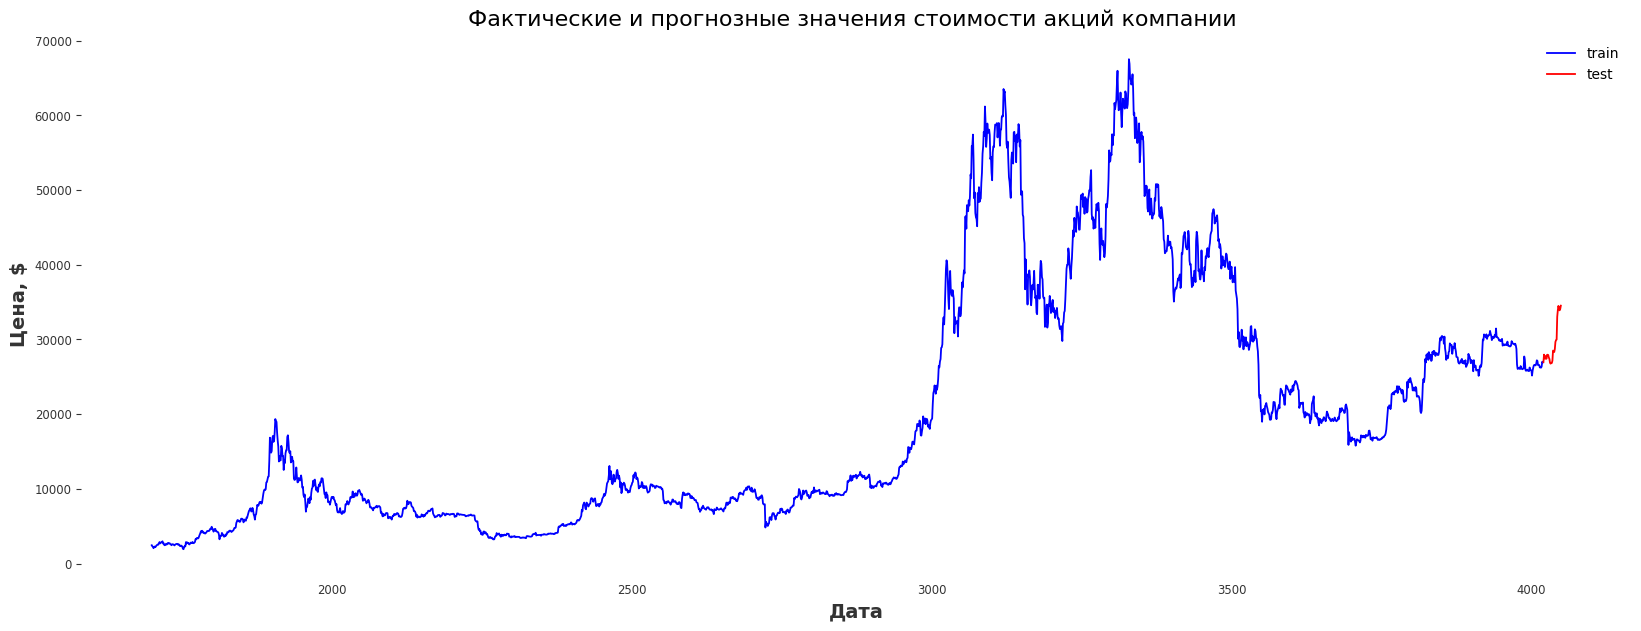

In [ ]:
num_shape = 4020

data = btc.iloc[1700:num_shape]
pred_data = btc.iloc[num_shape:num_shape+30]

plt.figure(figsize=(20,7))
plt.plot(train['close'], color = 'blue', label='train')
plt.plot(test['close'], color = 'red', label='test')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании ', fontsize = 16)
plt.show()

In [ ]:
data

,date,close,high,low,open,volume
1700,2017-05-24,2445.3,2272.6,2497.0,2263.3,149260.0
1701,2017-05-25,2307.2,2445.3,2781.8,2210.5,248440.0
1702,2017-05-26,2244.9,2307.0,2616.5,2051.4,191490.0
1703,2017-05-27,2052.4,2244.9,2322.4,1868.6,222950.0
1704,2017-05-28,2189.0,2052.4,2300.5,2051.1,125000.0
...,...,...,...,...,...,...
4015,2023-09-25,26302.7,26251.6,26423.6,26013.6,38200.0
4016,2023-09-26,26218.9,26303.1,26396.2,26093.4,26410.0
4017,2023-09-27,26366.1,26218.9,26836.9,26109.1,50800.0
4018,2023-09-28,27022.6,26368.2,27283.6,26339.4,64560.0


In [ ]:
series = TimeSeries.from_dataframe(data, time_col="date", value_cols="close")


In [ ]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
# series_scaled = series.copy()

In [9]:
covariates = datetime_attribute_timeseries(series, attribute="day_of_week", one_hot=True)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="month", one_hot=True))

In [ ]:
covariates_scaled = scaler.fit_transform(covariates)
# covariates_scaled = covariates.copy()

In [11]:
series_scaled = series_scaled.astype("float32")
covariates_scaled = covariates_scaled.astype("float32")

In [12]:
train, val = series_scaled.split_before(0.8)

In [18]:
train

<TimeSeries (DataArray) (date: 1855, component: 1, sample: 1)> Size: 7kB
array([[[ 2445.3]],

       [[ 2307.2]],

       [[ 2244.9]],

       ...,

       [[20577.2]],

       [[20572.3]],

       [[20720.4]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 15kB 2017-05-24 2017-05-25 ... 2022-06-21
  * component  (component) <U5 20B 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [13]:
model = TFTModel(
    input_chunk_length=30,
    output_chunk_length=7,
    hidden_size=16,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    add_relative_index=True,
    add_encoders=None,
    random_state=42,
)

In [14]:
model.fit(train, past_covariates=covariates_scaled, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 15.1 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=30, output_chunk_length=7, batch_size=16, n_epochs=100, add_encoders=None, random_state=42)

In [15]:
forecast = model.predict(n=30, past_covariates=covariates_scaled)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
forecast

<TimeSeries (DataArray) (date: 30, component: 1, sample: 1)> Size: 120B
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 240B 2022-06-22 2022-06-23 ... 2022-07-21
  * component  (component) object 8B 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
forecast = scaler.inverse_transform(forecast)

NameError: name 'scaler' is not defined